In [1]:
import numpy as np
from auxiliar_functions import TrainingData
import re
import os
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras import backend as K
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from matplotlib import pyplot as plt
from functools import partial, update_wrapper
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Função loss Customizada para magnitude
def mag_loss(y_pred, y_true, wall_val, xz_dict, name='mag_loss'):
    """
        File: mag_isolated_prediction.py
        Function Name: mag_loss
        Summary: Função de custo para rede neural
        Description: Loss que adiciona a diferença da magnitude como penalidade
    """
    # Magnitude dos valores reais
    M_t = K.sqrt(K.sum(K.square(y_true), axis=-1))
    # Magnitude dos valores previstos
    M_p = K.sqrt(K.sum(K.square(y_pred), axis=-1))
    for indx, xz in enumerate(xz_dict):
        if xz_dict[indx] == wall_val[indx]:
#             y_pred[indx] = tf.zeros(3)
            tf.Session().run(tf.assign(y_pred, tf.zeros(3)))
        

    return K.mean(K.square(y_pred - y_true), axis=-1) + K.abs(M_p - M_t)


In [3]:
tf.reset_default_graph()

In [4]:
model = Sequential()
model.add(Dense(10, input_shape=(868,3), activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(3, activation='tanh'))

In [5]:
# Carregando dados para Treinamento
ANN_FOLDER = '/home/lucashqr/Documentos/Cursos/Keras Training/'\
             'Virtual/estudos-dissert/Keras_Virtual/Ciclone/ANN_DATA/'

DATA = TrainingData(ANN_FOLDER, scaler_dir='../../Models/')


# Dados de treinamento
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = DATA.data_gen(test_split=0.25, load_sc=False, save_sc=True)

Shape of X_TRAIN:  (77, 868, 3)
Shape of Y_TRAIN:  (77, 868, 3)
Shape of X_TEST:  (26, 868, 3)
Shape of Y_TEST:  (26, 868, 3)


[0.49961754 0.5011504 ]
(868, 2)


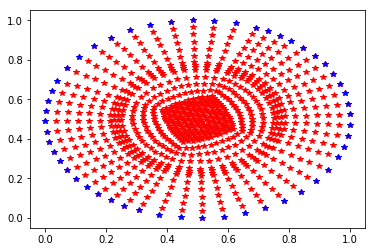

In [6]:
xz = X_TRAIN[..., :2][0]
print(np.mean(xz, axis=0))
#xz = DataFrame(xz)
print(xz.shape)
wall = []
A = np.array([np.mean(X_TRAIN[..., 0]) - np.max(X_TRAIN[..., 1]), 0])
for pnt in xz:    
    B = np.array(pnt) - np.array([np.mean(X_TRAIN[..., 0]), np.mean(X_TRAIN[..., 1])])
    if np.sqrt(np.sum(np.square(B))) >= 0.99*np.sqrt(np.sum(np.square(A))):
        wall.append([pnt])
wall = np.array(wall) # pontos da parede 'mais afastados do centro'

plt.plot(xz[:,0], xz[:,1], 'r*')
plt.plot(wall[..., 0], wall[..., 1], 'b*')

In [7]:
TB = TensorBoard(log_dir='./test_loss/Mag_zero_wall5/')
# Interromper Treinamento
ES = EarlyStopping(monitor='loss', min_delta=0.000001, patience=175,
                   restore_best_weights=True, )

# Reduzir taxa de aprendizagem
RLRP = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=70, verbose=1,
                         min_lr=1E-10)


new_mag = update_wrapper(partial(mag_loss, xz_dict=X_TRAIN[0,:2], wall_val=wall), mag_loss)

model.compile(optimizer='rmsprop', loss=new_mag)

model.fit(X_TRAIN, Y_TRAIN, epochs=30, batch_size=4, callbacks=[TB, ES, RLRP])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


Epoch 1/30
77/77 [==============================] - 1s 8ms/step - loss: 0.4436
Epoch 2/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 3/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2913
Epoch 4/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2875
Epoch 5/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2883
Epoch 6/30
77/77 [==============================] - 0s 3ms/step - loss: 0.2844
Epoch 7/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2803
Epoch 8/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2824
Epoch 9/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2765
Epoch 10/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2769
Epoch 11/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2750
Epoch 12/30
77/77 [==============================] - 0s 2ms/step - loss: 0.2696
Epoch 13/30
77/77 [==============================

In [8]:

# DF = [(read_csv(dado.path), re.findall(r'\d+\.?\d*_', dado.path)[0][:-1])
#               for dado in os.scandir(ANN_FOLDER)]

# XZ = np.array([np.array(sample) for sample in
#                        [dado[0][['Points:0', 'Points:2']] for dado in DF]])

#         # Valores de velocidade com o mesmo shape dos outros inputs
# INPUT_U = np.array([np.array(sample) for sample in
#                             [[float(dado[1])] * len(XZ[0]) for dado in DF]]).reshape(len(XZ), -1, 1)

# U_xyz = np.array([np.array(sample) for sample in
#                           [dado[0][['U:0', 'U:1', 'U:2']] for dado in DF]])

    

In [8]:
# Gerando dados para comparação com caso original
BASE_DIR ='./test_loss/Mag_zero_wall5/'
          
print(f"Gerando dados de previsão em {BASE_DIR}")
scaler_dict = DATA.return_scaler(load_sc=True)
VEL_ARR = np.array([[10.0]*868]).reshape(-1, 1)
VEL_ARR = scaler_dict['U_in'].transform(VEL_ARR).reshape(1, -1, 1)

# Valores previstos para Ux, Uy e Uz
PREDICs = model.predict(X_TRAIN[0, :].reshape(1, -1, 3))
print([p.shape for p in PREDICs])


# Retornando os dados para a escala anterior
Ux = DataFrame(scaler_dict['Ux_scaler'].inverse_transform(PREDICs[..., 0]).reshape(-1), columns=['U:0'])
Uy = DataFrame(scaler_dict['Uy_scaler'].inverse_transform(PREDICs[..., 1]).reshape(-1), columns=['U:1'])
Uz = DataFrame(scaler_dict['Uz_scaler'].inverse_transform(PREDICs[..., 2]).reshape(-1), columns=['U:2'])

# Inserindo valor dos pontos de Y
XYZ = read_csv(os.scandir(ANN_FOLDER).__next__().path)[['Points:0', 'Points:1', 'Points:2']]

# Geração de arquivo .CSV para leitura
FILENAME = f'NEW_SLICE_10_Isolated.csv'

SLICE_DATA = concat([Ux, Uy, Uz, XYZ], sort=True, axis=1)

# Escrevendo o header no formato do paraview
with open(BASE_DIR+FILENAME, 'w') as filename:
    HEADER = ''
    for col in list(SLICE_DATA.columns):
        HEADER += '\"' + col + '\",'
    filename.write(HEADER[:-1])
    filename.write('\n')

SLICE_DATA.to_csv(BASE_DIR + FILENAME, index=False, header=False, mode='a')
print("Dados de previsão copiados!")


# Diferença do valor previsto e o caso original
print("Calculando diferença...")
ORIGIN_DATA = read_csv(ANN_FOLDER+'SLICE_DATA_U_10_0.csv')

DIFF = SLICE_DATA[['U:0', 'U:1', 'U:2']] - ORIGIN_DATA[['U:0', 'U:1', 'U:2']]

RESULT_DATA = concat([DIFF, XYZ], axis=1)

print('Escrevendo dados DIFERENÇA')
RESULT_DATA.to_csv(BASE_DIR + 'DIFF_SLICE_U_10.csv', index=False)
print('Dados de diferença copiados!')


Gerando dados de previsão em ./test_loss/Mag_zero_wall5/
[(868, 3)]
Dados de previsão copiados!
Calculando diferença...
Escrevendo dados DIFERENÇA
Dados de diferença copiados!


In [9]:
model.save(BASE_DIR+'zero_wall_loss', overwrite=True, include_optimizer=True)